In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from pylab import rcParams
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
from tensorflow.keras.layers import Conv2D,Dense,GlobalMaxPooling2D,MaxPooling2D,BatchNormalization,Add
from tensorflow.keras.models import Sequential

In [52]:
training="E:/Projects/solar panel detection/dataset/training/"
label="E:/Projects/solar panel detection/dataset/labels_training.csv"

In [58]:
df=pd.read_csv(label)

In [59]:
df.head()

,id,label
0,0,0
1,1,0
2,2,1
3,3,1
4,4,1


In [63]:
# LOADING DATA AND PREPROCESSING

def load_data(dir_data, dir_labels):
    '''
    dir_data: Data directory
    dir_labels: Respective csv file containing ids and labels
    returns: Array of all the image arrays and its respective labels
    '''
    labels_pd = pd.read_csv(dir_labels)                         # Read the csv file with labels and ids as we saw above
    ids = labels_pd.id.values                                   # Extracting ids from the csv file
    data = []                                                   # Initiating the empty list to store each image as numpy array
    for identifier in ids:                                      # Looping into the desired folder
        fname = dir_data + identifier.astype(str) + '.jpg'      # Generating the file name
        image = mpl.image.imread(fname)                         # Reading image as numpy array using matplotlib
        data.append(image)                                      # Appending this array into the empty list and repeat the above cycle
    data = np.array(data)                                       # Now, convert the data list into data array
    labels = labels_pd.label.values                             # Extract labels from the csv file
    return data, labels                                         # Return the array of data and respective labels

In [64]:
X, y = load_data(training,label)

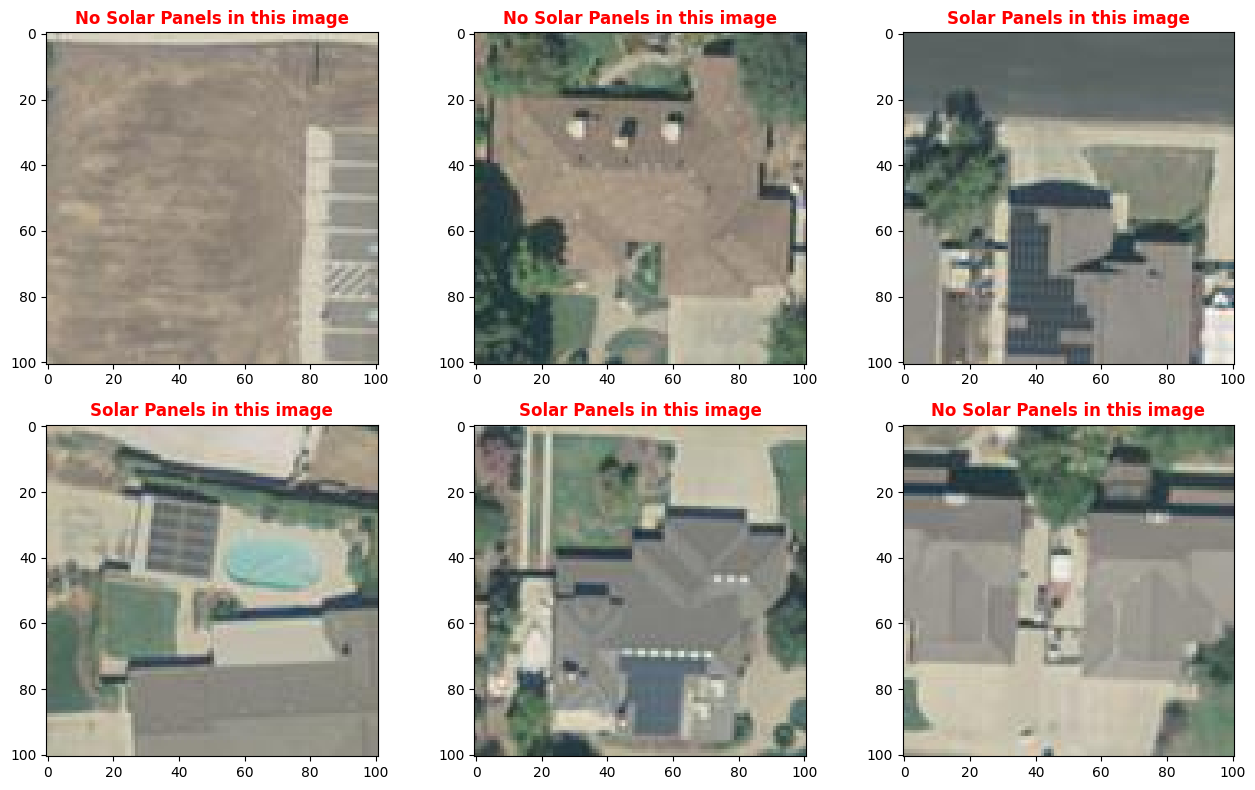

In [65]:
plt.figure(figsize = (13,8))                         # Adjust the figure size
for i in range(6):                                   # For first 6 images in the data
  plt.subplot(2, 3, i+1)                             # Create subplots
  plt.imshow(X[i])                                   # Show the respective image in respective postion
  if y[i] == 0:                                      # If label is 0
    title = 'No Solar Panels in this image'          # Set this as the title
  else:                                              # Else label is 1
    title = 'Solar Panels in this image'             # Set this as the title
  plt.title(title, color = 'r', weight = 'bold')     # Adding title to each images in the subplot
plt.tight_layout()                                   # Automatically adjusts the width and height between images in subplot
plt.show() 

In [66]:
print('X shape:\n', X.shape)
print('Distribution of y', np.bincount(y))
X = X / 255.0

X shape:
 (1500, 101, 101, 3)
Distribution of y [995 505]


In [69]:
def build_model():
    '''
    Returns a Keras CNN model
    '''

    # define image dimensions
    IMAGE_HEIGHT = 101
    IMAGE_WIDTH = 101
    IMAGE_CHANNELS = 3

    # define a straightforward sequential neural network
    model = Sequential()

    # layer-1
    #filter is convolutional matrix which is applied across the image = 32 filters
    #kernal size is 3x3 matrix(filter)
    #relu positive kept as it is, negative is taken out
    model.add(Conv2D(filters=32,
                     kernel_size=3,
                     activation='relu',
                     input_shape=(IMAGE_HEIGHT,
                                  IMAGE_WIDTH,
                                  IMAGE_CHANNELS)))

    #adding normalizing layer to improve the speed of training
    model.add(BatchNormalization())

    # As we move forword in the layers pattern gets more complex,
    # to capture the maximum combinations in subsequent layers
    # layer-2
    model.add(Conv2D(filters=64,
                     kernel_size=3,
                     activation='relu'))
    model.add(BatchNormalization())

    # layer-3
    model.add(Conv2D(filters=128,
                     kernel_size=3,
                     activation='relu'))
    model.add(BatchNormalization())

    # Pooling layer is to reduce dimentions of feature map by summerizing presence of features
    # max-pool - sends only imp data to next layer - here 2x2 matrix
    model.add(MaxPooling2D(pool_size=2))

    # layer-4
    model.add(Conv2D(filters=64,
                     kernel_size=3,
                     activation='relu'))
    model.add(BatchNormalization())

    # layer-5
    model.add(Conv2D(filters=128,
                     kernel_size=3,
                     activation='relu'))
    model.add(BatchNormalization())

    # max-pool
    model.add(MaxPooling2D(pool_size=2))

    # layer-6
    model.add(Conv2D(filters=64,kernel_size=3,activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(filters=128,kernel_size=3,activation='relu'))
    model.add(BatchNormalization())
    model.add(GlobalMaxPooling2D())

    # output layer
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model